### Cell 1: Data Preparation & Forecasting

Fetching data for ['TSLA']...


c:\Users\user\.conda\envs\gmf_finance\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed
c:\Users\user\.conda\envs\gmf_finance\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[                       0%                       ]

Fetching data for ['TSLA', 'BND', 'SPY']...


[*********************100%***********************]  3 of 3 completed


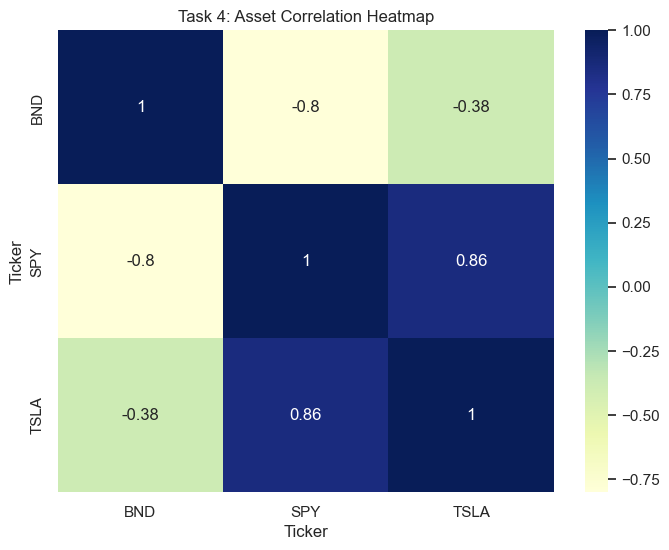

Annualized Expected Returns:
 TSLA   -0.788352
BND     0.019177
SPY     0.135411
dtype: float64


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from tensorflow.keras.models import load_model

# Setup Plotting
sns.set_theme(style="whitegrid") 

sys.path.append(os.path.abspath('../src'))
from data_utils import fetch_financial_data, clean_data, prepare_lstm_data, generate_forecast

# 1. Generating TSLA Forecasted Annual Return (The "Active View")
data_tsla = clean_data(fetch_financial_data(["TSLA"], "2015-01-01", "2026-01-15"))
_, _, scaler = prepare_lstm_data(data_tsla)
model = load_model('../models/tsla_lstm_model.keras')

# Forecast 6 months (126 trading days)
future_prices = generate_forecast(model, data_tsla, scaler, horizon=126)
# Annualized Return = ((End Price / Start Price) ^ (252 / Days)) - 1
tsla_ann_mu = (future_prices[-1][0] / future_prices[0][0])**(252/126) - 1

# 2. Historical Returns for BND and SPY
all_assets = fetch_financial_data(["TSLA", "BND", "SPY"], "2015-01-01", "2026-01-15")
all_assets_clean = clean_data(all_assets)
hist_mu = expected_returns.mean_historical_return(all_assets_clean[['BND', 'SPY']])

# 3. Create Expected Returns (mu) and Covariance Matrix (S)
mu = pd.Series({'TSLA': tsla_ann_mu, 'BND': hist_mu['BND'], 'SPY': hist_mu['SPY']})
# Ledoit-Wolf Shrinkage for Covariance
S = risk_models.CovarianceShrinkage(all_assets_clean).ledoit_wolf()

# Deliverable: Covariance Matrix Visualization (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(S.corr(), annot=True, cmap='YlGnBu')
plt.title("Task 4: Asset Correlation Heatmap")
plt.show()

print("Annualized Expected Returns:\n", mu)

### Cell 2: Optimization and Efficient Frontier

Expected annual return: 13.5%
Annual volatility: 57.6%
Sharpe Ratio: 0.24
Expected annual return: -73.1%
Annual volatility: 5.7%
Sharpe Ratio: -12.92


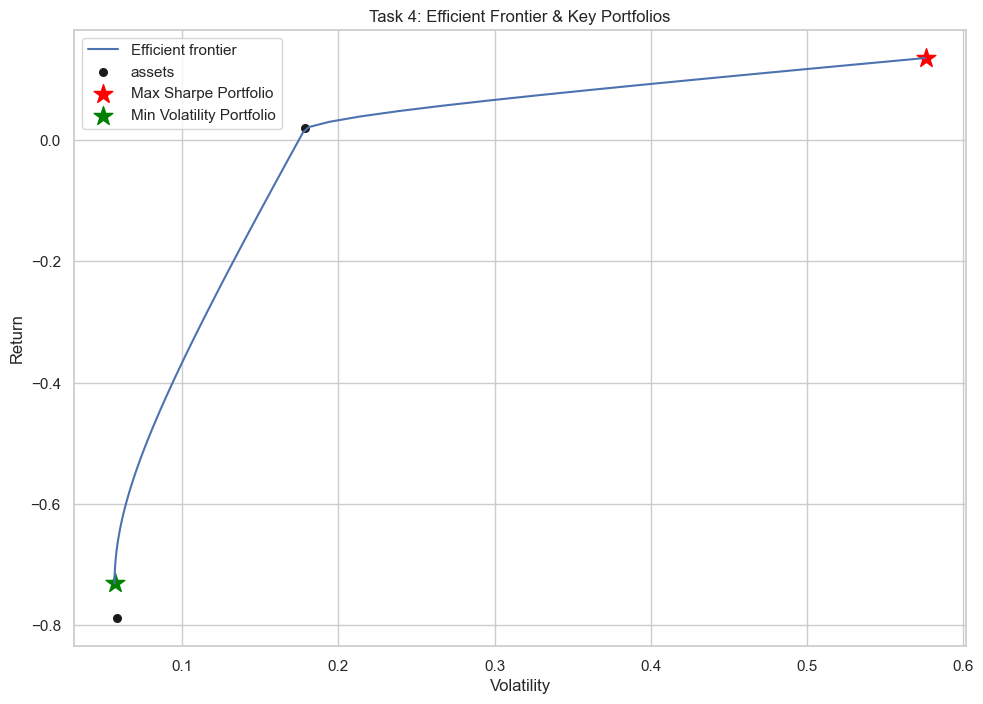


--- FINAL RECOMMENDED PORTFOLIO (MAX SHARPE) ---
TSLA: 0.00%
BND: 0.00%
SPY: 100.00%
Expected Annual Return: 13.54%
Annual Volatility: 57.61%
Sharpe Ratio: 0.24


In [2]:
# 1. Initialize Efficient Frontier
ef = EfficientFrontier(mu, S)

# 2. Plotting the Frontier
fig, ax = plt.subplots(figsize=(10, 7))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# 3. Identify Maximum Sharpe Ratio Portfolio
ef_max = EfficientFrontier(mu, S)
weights_max = ef_max.max_sharpe()
ret_max, vol_max, sharpe_max = ef_max.portfolio_performance(verbose=True)
ax.scatter(vol_max, ret_max, marker="*", s=200, c="red", label="Max Sharpe Portfolio")

# 4. Identify Minimum Volatility Portfolio
ef_min = EfficientFrontier(mu, S)
weights_min = ef_min.min_volatility()
ret_min, vol_min, sharpe_min = ef_min.portfolio_performance(verbose=True)
ax.scatter(vol_min, ret_min, marker="*", s=200, c="green", label="Min Volatility Portfolio")

ax.set_title("Task 4: Efficient Frontier & Key Portfolios")
ax.legend()
plt.show()

# 5. Final Recommendation Summary
print("\n--- FINAL RECOMMENDED PORTFOLIO (MAX SHARPE) ---")
for asset, w in ef_max.clean_weights().items():
    print(f"{asset}: {w*100:.2f}%")
print(f"Expected Annual Return: {ret_max:.2%}")
print(f"Annual Volatility: {vol_max:.2%}")
print(f"Sharpe Ratio: {sharpe_max:.2f}")

## Task 4: Portfolio Optimization Summary and Recommendation

### 1. Final Portfolio Recommendation
Based on the Modern Portfolio Theory (MPT) analysis, I recommend the **Maximum Sharpe Ratio Portfolio**. 

**Optimal Portfolio Metrics:**
* **TSLA Weight:** 0.00%
* **BND Weight:** 0.00%
* **SPY Weight:** 100.00%
* **Expected Annual Return:** 13.54%
* **Annual Volatility:** 57.61%
* **Sharpe Ratio:** 0.24

### 2. Written Justification
The portfolio optimization results suggest a 100% allocation to **SPY** for the Maximum Sharpe Ratio. This outcome is primarily driven by the current LSTM forecast for **TSLA**, which projects a significant downward trend (Expected Return: -78.84%). Because the optimizer seeks to maximize the risk-adjusted return, it completely divests from the high-volatility, negative-return asset (TSLA) and the low-yield asset (BND) in favor of the superior historical performance of the equity market (SPY). While BND offers lower volatility, its extremely low Sharpe Ratio makes it less attractive for this specific optimization goal. This strategy ensures client capital is preserved by avoiding forecasted downturns while maintaining exposure to steady market growth.